<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Copy_of_PINNs_wave_eq_v2_working_with_input_arrayx3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [ ]:
# install devito
!pip install devito &> /dev/null

In [ ]:
# import libraries and tools
import numpy as np
rng = np.random.default_rng()

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Cloning into 'MScDataSci_21-22'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 366 (delta 108), reused 29 (delta 17), pack-reused 188
Receiving objects: 100% (366/366), 11.48 MiB | 6.91 MiB/s, done.
Resolving deltas: 100% (223/223), done.


device(type='cuda', index=0)

In [ ]:
extent_x = 1.e3 ### METRES ###
extent_z = 1.e3 ### METRES ###

nx = 201 ### NODES ###
nz = 201 ### NODES ###

absorbingLayer = 10 ### NODES ###

nxTrue = nx + 2*absorbingLayer ### NODES ###
nzTrue = nz + 2*absorbingLayer ### NODES ###

dx = extent_x / (nx-1) ### METRES ###
dz = extent_z / (nz-1) ### METRES ###

shape = (nz, nx)
spacing = (dz, dx)
origin = (0., 0.)

# Define medium

In [ ]:
# define normalized 2D gaussian
def gaus2d(x, y, mx, my, sx, sy, peak):
    return peak * np.exp(-1*(((x-mx)**2/(2*sx**2)) + ((y-my)**2/(2*sy**2))))

# define medium (acoustic wavespeed)
v = np.empty(shape, dtype=np.float32)
speed = 1.
v[:, :] = speed ### KM/S ###
# v[:, int(shape[1]/2):] = 1.5  ### KM/S ###

x = np.arange(0, extent_x+dx, dx)
z = np.arange(0, extent_z+dz, dz)
x, z = np.meshgrid(x, z)
m = gaus2d(x, z, 1500., 750., 360., 60., -2.)

# v += m

1.0
1.0


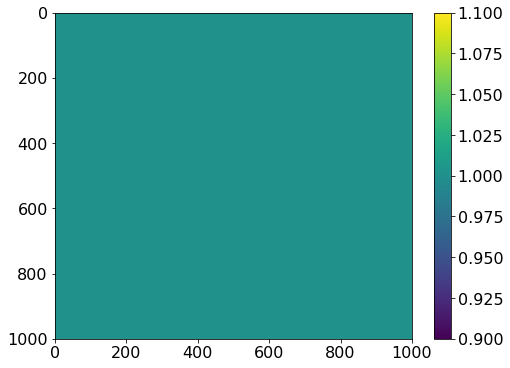

In [ ]:
fig, ax = plt.subplots()

plot = ax.pcolormesh(x, z, v)
ax.invert_yaxis()

fig.colorbar(plot)

print(v.min())
print(v.max())

In [ ]:
devitoModel = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=absorbingLayer, bcs="damp")

t0 = 0.  ### MILLISECONDS ###
# dt = 1e-1 ### MILLISECONDS ###
dt = devitoModel.critical_dt
T = 1.01e3 ### MILLISECONDS ###
nt = T / dt
time_range = TimeAxis(start=t0, stop=T, step=dt)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


In [ ]:
f0 = 0.01 ### kHZ ### # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=devitoModel.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 1] = int(extent_x*0.5) ### METRES ###
src.coordinates.data[0, 0] = int(extent_z*0.5) #extent_z*0.5 ### METRES ###

# rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)
# rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101) ### METRES ###
# rec.coordinates.data[:, 1] = 20.  ### METRES ###

# log all intermediate steps
u = TimeFunction(name="u", grid=devitoModel.grid, time_order=2, space_order=2, save=int(nt)+2)
pde = devitoModel.m * u.dt2 - u.laplace + devitoModel.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

src_term = src.inject(field=u.forward, expr=src * dt**2 / devitoModel.m)
# rec_term = rec.interpolate(expr=u.forward)

op = Operator([stencil] + src_term, subs=devitoModel.spacing_map) # + rec_term
# src.show()

In [ ]:
# log start time to measure performance
startTime = perf_counter()

# generate solution
summary = op.apply(time=int(nt), dt=dt)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

uInterior = u.data[:,
                   absorbingLayer:u.data.shape[1]-absorbingLayer,
                   absorbingLayer:u.data.shape[2]-absorbingLayer
                   ].copy()
uInterior.shape

Operator `Kernel` ran in 0.03 s
INFO:Devito:Operator `Kernel` ran in 0.03 s


Training duration: 0.34s


(331, 201, 201)

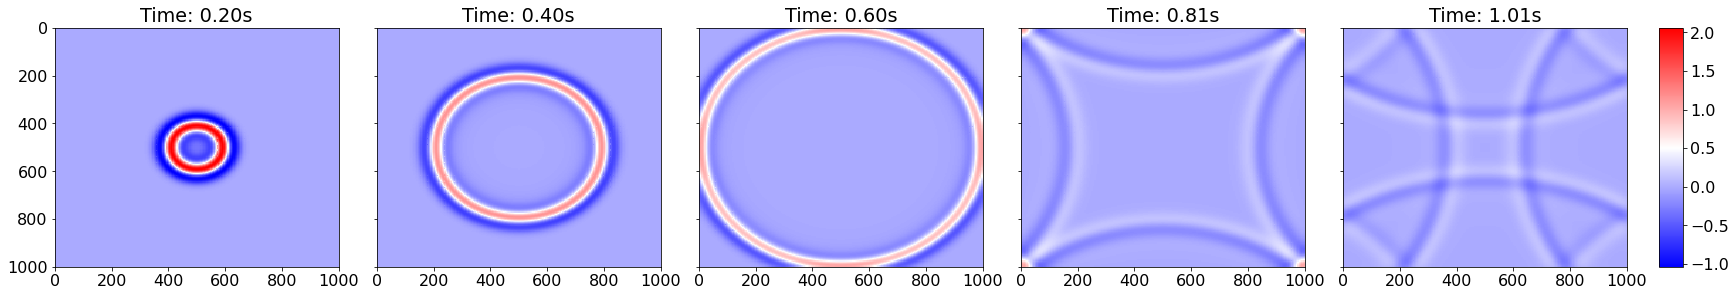

In [ ]:
numPlots = 5

# create arrays for plotting
# x = np.arange(0, nxTrue*dx, dx)
# y = np.arange(0, nzTrue*dz, dz)

x = np.arange(0, nx*dx, dx)
z = np.arange(0, nz*dz, dz)

# create normaliser for colorbar
plotData = np.empty(0)
for num in range(numPlots):
    plotData = np.append(plotData, np.array(uInterior[num*int(uInterior.shape[0]/numPlots)]))
norm = matplotlib.colors.Normalize(plotData.min(), plotData.max())

cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axs = plt.subplots(1, numPlots,
                        figsize=(24, 4),
                        constrained_layout=True,
                        sharey=True,
                        )
axs[0].invert_yaxis()

for idx, ax in enumerate(axs):
    # print(idx*int(u.data.shape[0]/numPlots) * (T / u.data.shape[0]))
    plot = ax.pcolormesh(x, z, uInterior[(idx+1)*int(uInterior.shape[0]/numPlots)], norm=norm, cmap='bwr')
    ax.set_title(f'Time: {1e-3 * (idx+1)*int(uInterior.shape[0]/numPlots) * (T / uInterior.shape[0]):.2f}s')

fig.colorbar(mapping, aspect=60)

plt.show()

## Shot record

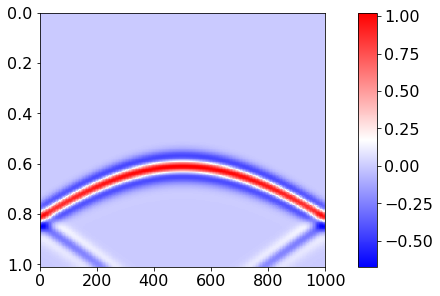

In [ ]:
# create arrays for plotting
# x = np.arange(0, nx*dx, dx)
t = np.arange(0, T+dt, dt) * 1.e-3

fig, ax = plt.subplots(#1, 5,
                        figsize=(6, 4),
                        constrained_layout=True,
                        # sharey=True,
                        )

# norm = matplotlib.colors.Normalize(results[:,:].min(),results[:,:].max())
# cmap = matplotlib.cm.get_cmap('bwr')
# mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

# for idx, ax in enumerate(axs):
plot = ax.pcolormesh(x, t, uInterior[:,0,:], cmap='bwr' )#norm=norm, cmap='bwr') # mesh_x, mesh_y,


ax.invert_yaxis()
fig.colorbar(plot)#, ax=axs.ravel(), aspect=60)

plt.show()

# PINN

PDE loss term is 20,000 points  
while 3,600 points are set for each of the early-time snapshot data

In [ ]:
Ns1 = 3600
Ns2 = 3600
Nf = 10000 #10000

Ns = Ns1 + Ns2
Nf_interior = Nf# - Ns

In [ ]:
s1 = 80
s2 = 120

print(f'Time extent: {T/1000}s')
print(f'ts1: {dt*s1/1000:.3f}s')
print(f'ts2: {dt*s2/1000:.3f}s')

Time extent: 1.01s
ts1: 0.245s
ts2: 0.367s


NsxArray consists of Nsx randomly sampled points from time sx (t, x, z, u)

In [ ]:
Ns1_xIdxs = rng.choice(nx, Ns1, replace=True)
Ns1_zIdxs = rng.choice(nz, Ns1, replace=True)

Ns1Array = np.array([
                     dt*s1*1.e-3 * np.ones(Ns1),
                     x[Ns1_xIdxs],
                     z[Ns1_zIdxs],
                     uInterior[s1, Ns1_zIdxs, Ns1_xIdxs],
                     ]).T

Ns2_xIdxs = rng.choice(nx, Ns2, replace=True)
Ns2_zIdxs = rng.choice(nz, Ns2, replace=True)

Ns2Array = np.array([
                     dt*s2*1.e-3 * np.ones(Ns2),
                     x[Ns2_xIdxs],
                     z[Ns2_zIdxs],
                     uInterior[s2, Ns2_zIdxs, Ns2_xIdxs],
                     ]).T

# NsArray = np.concatenate([Ns1Array, Ns2Array])

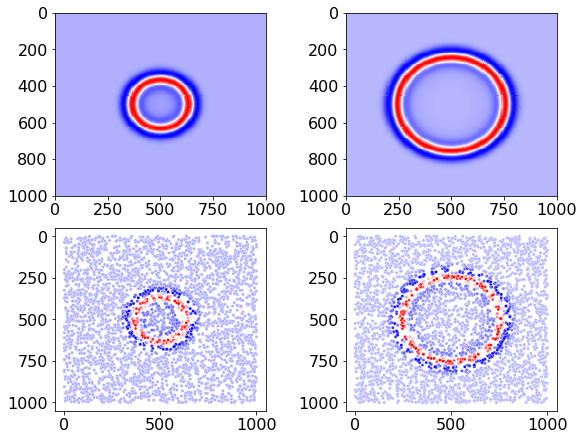

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True,)

ax1.pcolormesh(x, z, uInterior[s1], cmap='bwr')
ax1.invert_yaxis()
ax2.pcolormesh(x, z, uInterior[s2], cmap='bwr')
ax2.invert_yaxis()

sns.scatterplot(
    ax=ax3,
    x=Ns1Array[:,1],
    y=Ns1Array[:,2],
    hue=Ns1Array[:,3],
    palette='bwr',
    s=10,
    legend = False
    )
ax3.invert_yaxis()

sns.scatterplot(
    ax=ax4,
    x=Ns2Array[:,1],
    y=Ns2Array[:,2],
    hue=Ns2Array[:,3],
    palette='bwr',
    s=10,
    legend = False
    )
ax4.invert_yaxis()

plt.show()

In [ ]:
# create collocation training points selected uniformly randomly across input domain
# t - x - z
Nf_interiorArray = np.array([
                           rng.uniform(t0, T*1.e-3, Nf_interior),
                           rng.uniform(0, extent_x, Nf_interior),
                           rng.uniform(0, extent_z, Nf_interior),
                           ]).T

NfArray = np.concatenate([Nf_interiorArray])#, NsArray[:,:3]])

# NfArray = np.concatenate([Nf_interiorArray, NsArray[:,:3]])

NfArray.shape

(10000, 3)

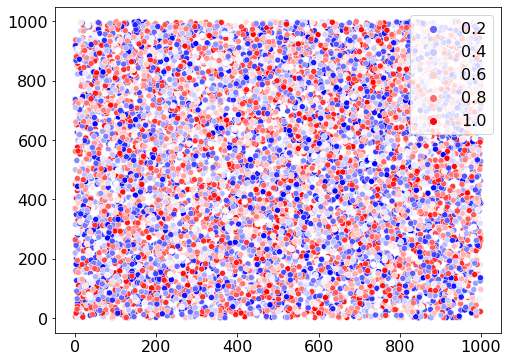

In [ ]:
sns.scatterplot(
    x=NfArray[:,1],
    y=NfArray[:,2],
    hue=NfArray[:,0],
    palette='bwr',
)
plt.show()

In [ ]:
# define physics informed neural network for 1D Burgers' equation
class PINN_2D_AcousticWave(torch.nn.Module):
    def __init__(self,
                 hiddenLayers,
                 nodesPerLayer,
                 activationFunction,
                 maxIterations,
                 maxEvaluations,
                 l1,
                 l2,
                 l3,
                 l4,
                 inverseProblem = False,
                 verbose = True
                 ):
        super(PINN_2D_AcousticWave, self).__init__()
        # network structure
        self.layers = torch.nn.ModuleList()
        self.activationFunction = activationFunction
        # input layer
        self.layers.append(torch.nn.Linear(3, nodesPerLayer))
        # hidden layers
        for _ in range(hiddenLayers):
            self.layers.append(torch.nn.Linear(nodesPerLayer, nodesPerLayer))
        # output layer
        self.layers.append(torch.nn.Linear(nodesPerLayer, 1))

        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.l4 = l4

        self.inverseProblem = inverseProblem
        # check if inverse problem
        # if self.inverseProblem:
        #     # add l1 and l2_exp as trainable parameters
        #     self.l1 = torch.nn.Parameter(torch.tensor(l1_init))
        #     self.l2_exp = torch.nn.Parameter(torch.tensor(l2_init))
        #     self.lxHistory = np.array([[l1_init, np.exp(l2_init)]])
        # # otherwise not trainable for forward problem
        # else:
        #     self.l1 = torch.tensor(l1_init)
        #     self.l2 = torch.tensor(l2_init)
        # boolean whether to print update during training
        self.verbose = verbose
        # define L-BFGS optimiser
        self.optimiser = torch.optim.LBFGS(
            self.parameters(),
            max_iter=maxIterations,
            max_eval=maxEvaluations,
            tolerance_change= 1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
            )

    # compute solution via forward pass
    def forward(self, X):
        input = X#torch.stack((t, x, z)).T
        for layer in self.layers[:-1]:
            input = self.activationFunction(layer(input))
        return self.layers[-1](input)

    # compute PDE residual
    def residual(self, X):
        # compute solution
        #https://stackoverflow.com/questions/69148622/difference-between-autograd-grad-and-autograd-backward#:~:text=In%20contrast%20torch.,a%20large%20number%20of%20parameters.
        u = self.forward(X).flatten()

        # u.backward(torch.ones_like(u)) # 

        # print(X.grad)

        # compute derivatives

        # print(u[:10])
        #RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([10000, 3]) and output[0] has a shape of torch.Size([10000, 1]).
        # print(X.shape)
        du_dNf = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]

        # print(du_dNf[:5])

        d2u_dt2 = torch.autograd.grad(du_dNf[:,0], X, torch.ones_like(u), create_graph=True)[0][:,0] #print(u[:10])
        d2u_dx2 = torch.autograd.grad(du_dNf[:,1], X, torch.ones_like(u), create_graph=True)[0][:,1]
        d2u_dz2 = torch.autograd.grad(du_dNf[:,2], X, torch.ones_like(u), create_graph=True)[0][:,2]

        # print(d2u_dt2[:5])

        # print(d2u_dNf2[:10,0])

        # print(du_dNf.shape)
        # print(d2u_dNf2.shape)

        m = 1.

        # compute PDE residual
        return d2u_dt2 - (d2u_dx2 + d2u_dz2) #m**2 * 

    def lossFunc(self, Ns1_u, Ns1_d, Ns2_u, Ns2_d, Nf_r):
        self.iterationCount += 1
        # compute constituent loss components

        # print(Ns1_u.shape)
        # print(Ns1_d.shape)
        # print(Ns2_u.shape)
        # print(Ns2_d.shape)
        # print(Nf_r.shape)

        snapshot1Loss = torch.mean(torch.square(Ns1_d - Ns1_u))
        snapshot2Loss = torch.mean(torch.square(Ns2_d - Ns2_u))
        residualLoss = torch.mean(torch.square(Nf_r))
        totalLoss = self.l2*snapshot1Loss + self.l2*snapshot2Loss + self.l1*residualLoss
        # store losses
        self.history = np.append(self.history,
                                 np.array([
                                           [totalLoss.item()],
                                           [snapshot1Loss.item()],
                                           [snapshot2Loss.item()],
                                           [residualLoss.item()]
                                           ]).T,
                                 axis=0)
        # check if inverse problem
        # if self.inverseProblem:
        #     # store l1 and l2 training history
        #     self.lxHistory = np.append(self.lxHistory,
        #                          np.array([
        #                                    [self.l1.item()],
        #                                    [self.l2.item()],
        #                                    ]).T,
        #                          axis=0)
        # print training progress update (every (2**2)th epoch initially, then every 500th)
        if self.verbose and ((np.log2(self.iterationCount) % 1 == 0 and self.iterationCount < 500) or self.iterationCount % 500 == 0):
            print(f'Epoch: {self.iterationCount} --- Elapsed time: {(perf_counter()-self.startTime):.2f}s --- Loss: {self.history[-1,0]}')
        return totalLoss

    # def normalise(self, array, max):
    #     return 2*array/max - 1

    # def unnormalise(self, array, max):
    #     return (array + 1)*0.5*max

    # def prepareTrainInput(self, Ns1Array, Ns2Array, NfArray):
    #     #(X, label) = (X.to(device), label.to(device))

    #     self.tMax = np.concatenate([Ns1Array[:,0], Ns2Array[:,0], NfArray[:,0]]).max()
    #     self.xMax = np.concatenate([Ns1Array[:,1], Ns2Array[:,1], NfArray[:,1]]).max()
    #     self.zMax = np.concatenate([Ns1Array[:,2], Ns2Array[:,2], NfArray[:,2]]).max()
    #     self.dMax = np.concatenate([Ns1Array[:,3], Ns2Array[:,3]]).max()

    #     Ns1_t = torch.from_numpy(self.normalise(Ns1Array[:,0], self.tMax).astype(np.float32)).requires_grad_().to(device)
    #     Ns1_x = torch.from_numpy(self.normalise(Ns1Array[:,1], self.xMax).astype(np.float32)).requires_grad_().to(device)
    #     Ns1_z = torch.from_numpy(self.normalise(Ns1Array[:,2], self.zMax).astype(np.float32)).requires_grad_().to(device)
    #     Ns1_d = torch.from_numpy(self.normalise(Ns1Array[:,3], self.dMax).astype(np.float32).reshape(Ns1Array.shape[0],1)).to(device)
        
    #     Ns2_t = torch.from_numpy(self.normalise(Ns2Array[:,0], self.tMax).astype(np.float32)).requires_grad_().to(device)
    #     Ns2_x = torch.from_numpy(self.normalise(Ns2Array[:,1], self.xMax).astype(np.float32)).requires_grad_().to(device)
    #     Ns2_z = torch.from_numpy(self.normalise(Ns2Array[:,2], self.zMax).astype(np.float32)).requires_grad_().to(device)
    #     Ns2_d = torch.from_numpy(self.normalise(Ns2Array[:,3], self.dMax).astype(np.float32).reshape(Ns2Array.shape[0],1)).to(device)
    #     # Prepare Nf training tensors
    #     Nf_t = torch.from_numpy(self.normalise(NfArray[:,0], self.tMax).astype(np.float32)).requires_grad_().to(device)
    #     Nf_x = torch.from_numpy(self.normalise(NfArray[:,1], self.xMax).astype(np.float32)).requires_grad_().to(device)
    #     Nf_z = torch.from_numpy(self.normalise(NfArray[:,2], self.zMax).astype(np.float32)).requires_grad_().to(device)

    #     return Ns1_t, Ns1_x, Ns1_z, Ns1_d,\
    #     Ns2_t, Ns2_x, Ns2_z, Ns2_d,\
    #     Nf_t, Nf_x, Nf_z

    def trainer(self, Ns1Array, Ns2Array, NfArray):
        # set to train mode
        self.train()
        # initialise variables to track progress
        self.history = np.empty((0,4), float)
        self.iterationCount = 0
        self.startTime = perf_counter()
        # Prepare training tensors
        # Ns1_t, Ns1_x, Ns1_z, Ns1_d,\
        # Ns2_t, Ns2_x, Ns2_z, Ns2_d,\
        # Nf_t, Nf_x, Nf_z = self.prepareTrainInput(Ns1Array, Ns2Array, NfArray)
        Ns1Tens = torch.from_numpy(Ns1Array[:,:-1].astype(np.float32)).requires_grad_().to(device)
        # Ns1_d = torch.from_numpy(self.normalise(Ns1Array[:,3], self.dMax).astype(np.float32).reshape(Ns1Array.shape[0],1)).to(device)
        Ns1_d = torch.from_numpy(Ns1Array[:,-1].astype(np.float32).reshape(Ns1Array.shape[0],1)).to(device)

        Ns2Tens = torch.from_numpy(Ns2Array[:,:-1].astype(np.float32)).requires_grad_().to(device)
        Ns2_d = torch.from_numpy(Ns2Array[:,-1].astype(np.float32).reshape(Ns2Array.shape[0],1)).to(device)

        NfTens = torch.from_numpy(NfArray.astype(np.float32)).requires_grad_().to(device)

        # define closure function for L-BFGS optimiser
        def closure():
            self.optimiser.zero_grad()
            Ns1_u = self.forward(Ns1Tens)
            Ns2_u = self.forward(Ns2Tens)
            Nf_r = self.residual(NfTens)
            lossValue = self.lossFunc(Ns1_u, Ns1_d, Ns2_u, Ns2_d, Nf_r)
            lossValue.backward()
            return lossValue
        # run optimiser
        self.optimiser.step(closure)
        # training complete, set to evaluation mode
        self.eval()

    # def tester(self, NArray):
    #     N_t, N_x, N_z = self.prepareTestInput(NArray)
    #     uTensor = self.forward(N_t, N_x, N_z)

    #     uArrayFlat = self.unnormalise(uTensor.cpu().detach().numpy(), self.dMax) #.cpu().detach().numpy().
        
    #     # unnormalise(self, array, max)
    #     # torch.reshape(uTensor, (numPlots+1, nz, nx)).detach().numpy()
    #     return uArrayFlat

    # def prepareTestInput(self, NArray):
    #     N_t = torch.from_numpy(self.normalise(NArray[:,0], self.tMax).flatten().astype(np.float32)).to(device)
    #     N_x = torch.from_numpy(self.normalise(NArray[:,1], self.xMax).flatten().astype(np.float32)).to(device)
    #     N_z = torch.from_numpy(self.normalise(NArray[:,2], self.zMax).flatten().astype(np.float32)).to(device)

    #     return N_t, N_x, N_z

    # def medium(self, x, z):
        
    #     return (1. * torch.ones(x.shape[0])).to(device)# + (z > 500) * 1.
        # return 1.e3 * torch.ones(x.shape[0]) # + (y > 500) * 1.e3

In [ ]:
# define network characteristics
hiddenLayers = 4
nodesPerLayer = 50
activationFunction = nn.Tanh()
# activationFunction = nn.functional(torch.sin)
maxIterations = 50000
maxEvaluations = 50000
l1 = 0.1 # residual (PDE)
l2 = 1. # snapshots
l3 = 0.
l4 = 0.
inverseProblem = False

model = PINN_2D_AcousticWave(hiddenLayers, nodesPerLayer, activationFunction, maxIterations, maxEvaluations, l1, l2, l3, l4, inverseProblem)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

model = model.to(device)

Network parameters: 10451


In [ ]:
maxArray = np.array([
    T*1e-3,
    extent_x,
    extent_z,
    max(Ns1Array[:,-1].max(), Ns2Array[:,-1].max()),
])

In [ ]:
Ns1Norm = 2*Ns1Array/maxArray -1
Ns2Norm = 2*Ns2Array/maxArray - 1
NfNorm = 2*NfArray/maxArray[:-1] - 1

In [ ]:
model.trainer(Ns1Norm, Ns2Norm, NfNorm)

Epoch: 1 --- Elapsed time: 0.03s --- Loss: 1.701066255569458
Epoch: 2 --- Elapsed time: 0.06s --- Loss: 1.5517795085906982
Epoch: 4 --- Elapsed time: 0.11s --- Loss: 0.29955166578292847
Epoch: 8 --- Elapsed time: 0.22s --- Loss: 0.20697227120399475
Epoch: 16 --- Elapsed time: 0.44s --- Loss: 0.20644162595272064
Epoch: 32 --- Elapsed time: 0.92s --- Loss: 0.20633651316165924
Epoch: 64 --- Elapsed time: 2.00s --- Loss: 0.20630399882793427
Epoch: 128 --- Elapsed time: 4.47s --- Loss: 0.20626139640808105
Epoch: 256 --- Elapsed time: 9.71s --- Loss: 0.20609597861766815
Epoch: 500 --- Elapsed time: 19.81s --- Loss: 0.20560795068740845
Epoch: 1000 --- Elapsed time: 40.62s --- Loss: 0.18761101365089417
Epoch: 1500 --- Elapsed time: 61.68s --- Loss: 0.17387759685516357
Epoch: 2000 --- Elapsed time: 83.47s --- Loss: 0.14905112981796265
Epoch: 2500 --- Elapsed time: 105.67s --- Loss: 0.1243874803185463
Epoch: 3000 --- Elapsed time: 127.15s --- Loss: 0.11247032880783081
Epoch: 3500 --- Elapsed tim

KeyboardInterrupt: ignored

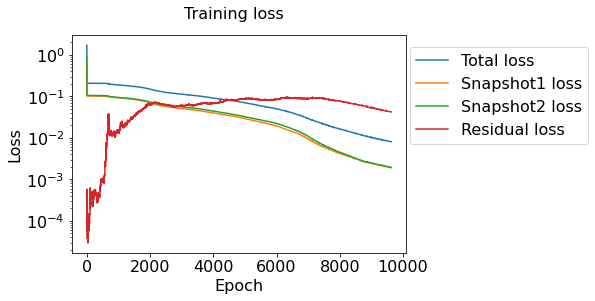

In [ ]:
fig = utilityFunctions.trainingHistoryPlot(model.history,
                                           ['Total loss', 'Snapshot1 loss', 'Snapshot2 loss', 'Residual loss'],
                                           'Loss',
                                           'Training loss',
                                           yLogAx=True,
                                           )

## Plots
Compute u from PINN for all t, x, z in same results form as Devito (np array: t-z-x)

In [ ]:
numPlots = 5
# t = np.arange(0.012, 0.030, 0.003)
tPlot = 1000*1.e-3

t = np.arange(0, tPlot+tPlot/numPlots, tPlot/numPlots)

x = np.arange(0, nx*dx, dx)
z = np.arange(0, nz*dz, dz)

# x = np.arange(0, extent_x+500., 500.)
# z = np.arange(0, extent_z+500., 500.)

xArray, tArray, zArray = np.meshgrid(x, t, z)
NArray = np.stack((tArray.flatten(), xArray.flatten(), zArray.flatten())).T

uTensFlat = model(torch.from_numpy((2*NArray/maxArray[:-1] - 1).astype(np.float32)).to(device))
uArray = np.reshape(uTensFlat.cpu().detach().numpy(), (numPlots+1, nz, nx))

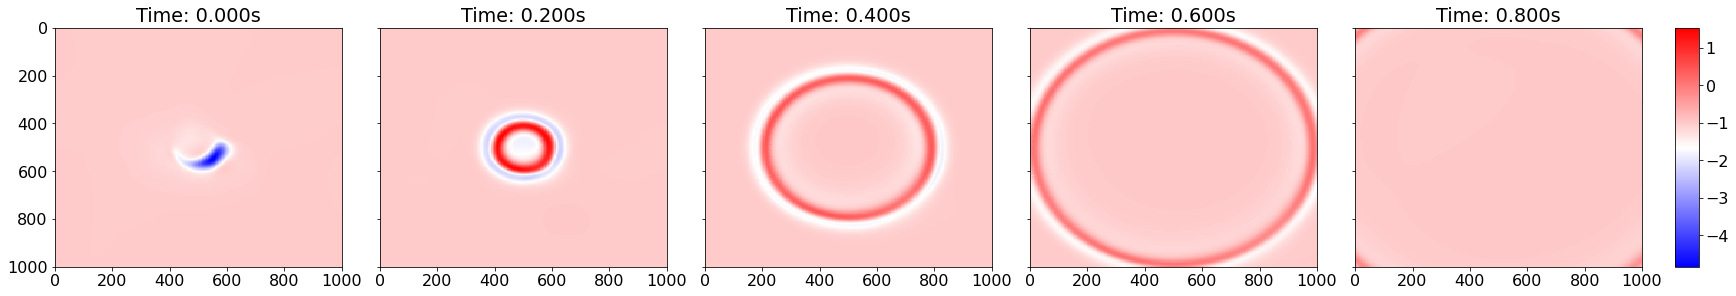

In [ ]:
norm = matplotlib.colors.Normalize(uArray.min(), uArray.max())

cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axs = plt.subplots(1, numPlots,
                        figsize=(24, 4),
                        constrained_layout=True,
                        sharey=True,
                        )
axs[0].invert_yaxis()

for idx, ax in enumerate(axs):
    # print(idx*int(u.data.shape[0]/numPlots) * (T / u.data.shape[0]))
    plot = ax.pcolormesh(x, z, uArray[idx], norm=norm, cmap='bwr')
    ax.set_title(f'Time: {t[idx]:.3f}s')

fig.colorbar(mapping, aspect=60)

plt.show()

In [ ]:
print(f'{(dt*s1/1000):.2f}')
print(f'{(dt*s2/1000):.2f}')

0.18
0.31


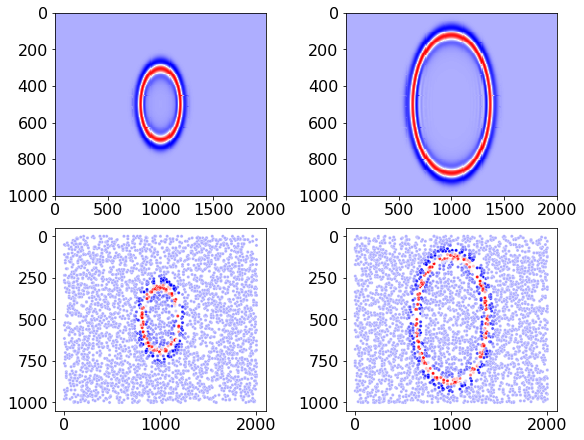

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True,)

ax1.pcolormesh(x, z, uInterior[s1], cmap='bwr')
ax1.invert_yaxis()
ax2.pcolormesh(x, z, uInterior[s2], cmap='bwr')
ax2.invert_yaxis()

sns.scatterplot(
    ax=ax3,
    x=Ns1Array[:,1],
    y=Ns1Array[:,2],
    hue=Ns1Array[:,3],
    palette='bwr',
    s=10,
    legend = False
    )
ax3.invert_yaxis()

sns.scatterplot(
    ax=ax4,
    x=Ns2Array[:,1],
    y=Ns2Array[:,2],
    hue=Ns2Array[:,3],
    palette='bwr',
    s=10,
    legend = False
    )
ax4.invert_yaxis()

plt.show()